In [ ]:
x#!pip install --upgrade keras

In [ ]:
#!pip install --upgrade tensorflow

In [ ]:
from PIL import Image
import dask.dataframe as dd
import os
import pydicom as dicom

from tensorflow import keras

os.environ["KERAS_BACKEND"] = "jax"

from keras import Sequential, layers, ops
from keras.layers import Dense, Flatten, Conv3D, Conv2D, MaxPooling3D
from keras.utils import to_categorical

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import os
import sys

In [ ]:
X = np.load('/content/silvia_cache/X.npy')
y = np.load('/content/silvia_cache/y.npy')

Image shape: (256, 256)


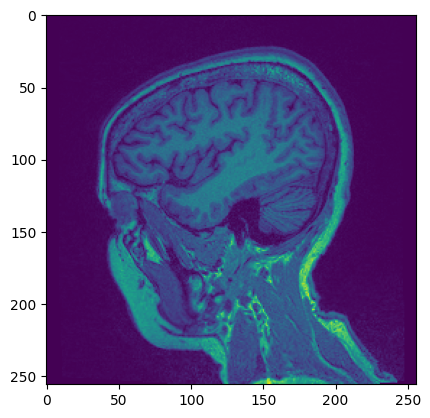

In [ ]:
pixels = X[0]
print('Image shape:', pixels.shape)
plt.imshow(pixels)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

X_train, X_test = X_train.reshape((*X_train.shape, 1)), X_test.reshape((*X_test.shape, 1))
y_train, y_test = y_train.reshape(-1,1), y_test.reshape(-1,1)
del X
del y
# y_train_onehot, y_val_onehot, y_test_onehot = to_categorical(y_train), to_categorical(y_val), to_categorical(y_test)

In [ ]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(16332, 256, 256, 1)

(16332, 1)

(4084, 256, 256, 1)

(4084, 1)

In [ ]:
num_classes = 3
input_shape = (256, 256, 1)

In [ ]:
# Confuguring hyperparameters

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 256
patch_size = 18  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [
    2048,
    1024,
]

In [ ]:
#Data augmentation layer
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [ ]:
#Creating MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=keras.activations.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
# Patch Creation as a layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        input_shape = ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size=self.patch_size)
        patches = ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels,
            ),
        )
        return patches

    def get_config(self):
        config = super().get_config()
        config.update({"patch_size": self.patch_size})
        return config


Image size: 256 X 256
Patch size: 18 X 18
Patches per image: 196
Elements per patch: 324


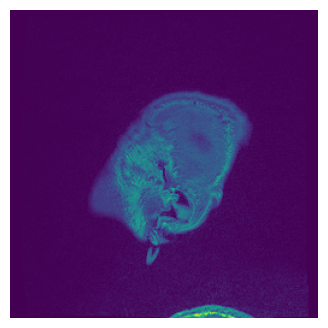

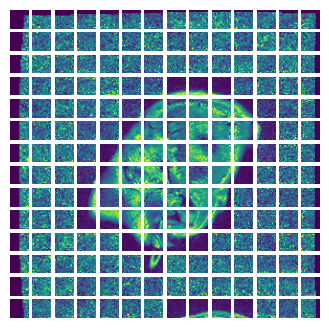

In [ ]:
# Visualization

plt.figure(figsize=(4, 4))
image = X_train[100]#np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = ops.image.resize(
    ops.convert_to_tensor([image], dtype=np.float32), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = ops.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(ops.convert_to_numpy(patch_img))
    plt.axis("off")

del image
del resized_image
del patches

In [ ]:
#Patch Encoding Layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

In [ ]:
# Building the ViT model
def create_vit_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 78s 648ms/step - accuracy: 0.4686 - loss: 4.5039 - val_accuracy: 0.5312 - val_loss: 1.0629
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 604ms/step - accuracy: 0.5617 - loss: 1.0278 - val_accuracy: 0.5930 - val_loss: 0.9939
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 563ms/step - accuracy: 0.5909 - loss: 0.9825 - val_accuracy: 0.5930 - val_loss: 0.9973
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 565ms/step - accuracy: 0.5856 - loss: 0.9813 - val_accuracy: 0.5930 - val_loss: 0.9562
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 563ms/step - accuracy: 0.5881 - loss: 0.9776 - val_accuracy: 0.5930 - val_loss: 0.9488
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 563ms/step - accuracy: 0.5844 - loss: 0.9708 - val_accuracy: 0.5930 - val_loss: 0.9526
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 33s 564ms/step - accuracy: 0.5892 - loss: 0.9650 - val_accuracy: 0.5930 - val_loss: 0.9415
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 35s 602ms/step - accuracy: 0.5811 - loss: 0.9626 - 

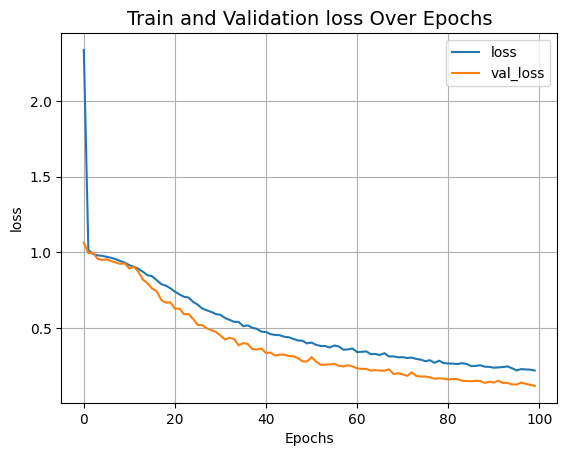

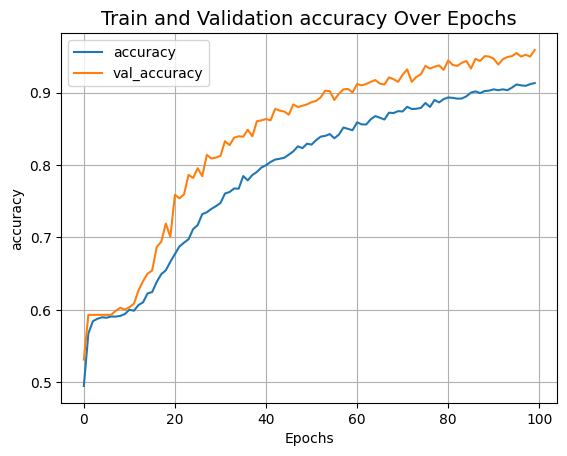

In [ ]:
#Compilation, training, evaluation

np.random.seed(30)

def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy")
        ],
    )

    checkpoint_filepath = "/shree_cache/tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=X_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history


vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

vit_classifier.save('/shree_cache/vit_model.keras')

def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")